In [35]:
import PySimpleGUI as sg
from tkinter import W
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import time,os
# import psutil
import collections
import csv
from scipy.signal import find_peaks
import scipy
import pandas as pd
from matplotlib.patches import Rectangle
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import get_window
import statistics
from PIL import Image
import io
import sys
import glob
import numpy as np
import glob,os,sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scanpy as sc
from scipy import stats

In [36]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.12 ; cuda:  1.12.1
detectron2: 0.6


In [37]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [38]:
from detectron2.data.datasets import register_coco_instances

In [39]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [40]:
import matplotlib
def db(box_coord, alpha=0.5, edge_color="g", line_style="-"):
    x0, y0, x1, y1 = box_coord
    width = x1 - x0
    height = y1 - y0
    mp = matplotlib.patches.Rectangle(
          (x0, y0),
          width,
          height,
          fill=False,
          color='green'
      )
    return mp

In [41]:
# get dax file into usable format
def readdax(fl): return np.frombuffer(open(fl,'rb').read(),dtype=np.uint16).reshape((-1,2048,2048))
#get specific z_slice
def get_frame(dax_fl,ind_z=1,sx=2048,sy=2048):
    "returns single frame of a dax file"
    f = open(dax_fl, "rb")
    bytes_frame = sx*sy*2
    f.seek(bytes_frame*ind_z)
    im_ = np.fromfile(f,dtype=np.uint16,count=sx*sy).reshape([sx,sy]).swapaxes(0,1)
    f.close()
    return im_
import cv2
#subtract 15x15 Gaussian blur
def norm_slice(im,divide,s):
    im_=im.astype(np.float32)
    if divide:
        return np.array([im__/cv2.blur(im__,(s,s)) for im__ in im_],dtype=np.float32)
    return np.array([im__-(cv2.blur(im__,(s,s))) for im__ in im_],dtype=np.float32)

In [42]:
#Get positions of microscope for each FOV
def readInfoFile(info_fl,parms = ['stage_position','x_pixels','y_pixels','number_frames']):
    info_fl = info_fl.replace('.dax','.xml').replace('.inf','.xml').replace('.zst','')
    dic = {}
    fid  = open(info_fl,'r')
    for ln in fid:
        for parm in parms:
            if '<'+parm in ln:
                value_str = ln.split('>')[1].split('<')[0]
                dic[parm]=eval(value_str)
    dic['Stage X']=dic['stage_position'][0]
    dic['Stage Y']=dic['stage_position'][1]
    fid.close()
    return dic

def get_pos(dax,pix_size = 0.108):
    dic_inf = readInfoFile(dax)
    return [-dic_inf['Stage X']/pix_size,dic_inf['Stage Y']/pix_size]

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [43]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


In [44]:
import glob
import os
import numpy as np
import PIL
from tqdm import tqdm
from PIL import Image

#getting the channel of the fiducial beads
def get_im_beads(dax_fl,ncols=3,nfr = 3,dtype=np.float32):
    return np.array([get_frame(dax_fl,ind_z=ind_z,sx=2048,sy=2048) for ind_z in np.arange(ncols-1,ncols*nfr,ncols)],dtype=dtype)


def load_segmentation(segmask_dir, type='png'):
    segm = []
    cell_count = 0
    print("Loading segmentation masks...")
    if (type=='png'):
        for file in tqdm(np.sort(glob.glob(os.path.join(segmask_dir, "*_cp_masks.png")))):
            segm.append(np.asarray(Image.open(file)))
            cell_count += np.max(segm[-1])
    elif (type=='npy'):
        for file in tqdm(glob.glob(os.path.join(segmask_dir, "*_seg.npy"))):
            segm.append(np.load(file,allow_pickle=True))
            cell_count += np.max(segm[-1])
    else:
        print("Type must be either 'png' or 'npy'")
    print(cell_count, "cells found")
    return segm

In [45]:
from scipy.spatial.distance import cdist
def get_best_trans(Xh1,Xh2,th_h=1,th_dist = 2,return_pairs=False):
    mdelta = np.array([np.nan,np.nan,np.nan])
    if len(Xh1)==0 or len(Xh2)==0:
        if return_pairs:
            return mdelta,[],[]
        return mdelta
    X1,X2 = Xh1[:,:3],Xh2[:,:3]
    h1,h2 = Xh1[:,-1],Xh2[:,-1]
    i1 = np.where(h1>th_h)[0]
    i2 = np.where(h2>th_h)[0]
    if len(i1)==0 or len(i2)==0:
        if return_pairs:
            return mdelta,[],[]
        return mdelta
    i2_ = np.argmin(cdist(X1[i1],X2[i2]),axis=-1)
    i2 = i2[i2_]
    deltas = X1[i1]-X2[i2]
    dif_ = deltas
    bins = [np.arange(m,M+th_dist*2+1,th_dist*2) for m,M in zip(np.min(dif_,0),np.max(dif_,0))]
    hhist,bins_ = np.histogramdd(dif_,bins)
    max_i = np.unravel_index(np.argmax(hhist),hhist.shape)

    center_ = [(bin_[iM_]+bin_[iM_+1])/2. for iM_,bin_ in zip(max_i,bins_)]
    keep = np.all(np.abs(dif_-center_)<=th_dist,-1)
    center_ = np.mean(dif_[keep],0)
    for i in range(5):
        keep = np.all(np.abs(dif_-center_)<=th_dist,-1)
        center_ = np.mean(dif_[keep],0)
    mdelta = center_
    keep = np.all(np.abs(deltas-mdelta)<=th_dist,1)
    if return_pairs:
        return mdelta,Xh1[i1[keep]],Xh2[i2[keep]]
    return mdelta

In [46]:
def get_local_max(im_dif,th_fit,delta=2,delta_fit=3,dbscan=True,return_centers=False,mins=None):
    """Given a 3D image <im_dif> as numpy array, get the local maxima in cube -<delta>_to_<delta> in 3D.
    Optional a dbscan can be used to couple connected pixels with the same local maximum. 
    (This is important if saturating the camera values.)
    Returns: Xh - a list of z,x,y and brightness of the local maxima
    """
    
    z,x,y = np.where(im_dif>th_fit)
    zmax,xmax,ymax = im_dif.shape
    in_im = im_dif[z,x,y]
    keep = np.ones(len(x))>0
    for d1 in range(-delta,delta+1):
        for d2 in range(-delta,delta+1):
            for d3 in range(-delta,delta+1):
                keep &= (in_im>=im_dif[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])
    z,x,y = z[keep],x[keep],y[keep]
    h = in_im[keep]
    Xh = np.array([z,x,y,h]).T

    if dbscan and len(Xh)>0:
        from scipy import ndimage
        im_keep = np.zeros(im_dif.shape,dtype=bool)
        im_keep[z,x,y]=True
        lbl, nlbl = ndimage.label(im_keep,structure=np.ones([3]*3))
        l=lbl[z,x,y]#labels after reconnection
        ul = np.arange(1,nlbl+1)
        il = np.argsort(l)
        l=l[il]
        z,x,y,h = z[il],x[il],y[il],h[il]
        inds = np.searchsorted(l,ul)
        Xh = np.array([z,x,y,h]).T
        Xh_ = []
        for i_ in range(len(inds)):
            j_=inds[i_+1] if i_<len(inds)-1 else len(Xh)
            Xh_.append(np.mean(Xh[inds[i_]:j_],0))
        Xh=np.array(Xh_)
        z,x,y,h = Xh.T
    im_centers=[]
    if delta_fit!=0 and len(Xh)>0:
        z,x,y,h = Xh.T
        z,x,y = z.astype(int),x.astype(int),y.astype(int)
        im_centers = [[],[],[],[]]
        for d1 in range(-delta_fit,delta_fit+1):
            for d2 in range(-delta_fit,delta_fit+1):
                for d3 in range(-delta_fit,delta_fit+1):
                    if (d1*d1+d2*d2+d3*d3)<=(delta_fit*delta_fit):
                        im_centers[0].append((z+d1))
                        im_centers[1].append((x+d2))
                        im_centers[2].append((y+d3))
                        im_centers[3].append(im_dif[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])

        im_centers_ = np.array(im_centers)
        im_centers_[-1] -= np.min(im_centers_[-1],axis=0)
        zc = np.sum(im_centers_[0]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        xc = np.sum(im_centers_[1]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        yc = np.sum(im_centers_[2]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        Xh = np.array([zc,xc,yc,h]).T
    if return_centers:
        return Xh,np.array(im_centers)
    return Xh

In [47]:
from sklearn.neighbors import NearestNeighbors
import pickle
from scipy import ndimage

def resize(im,shape_ = [50,2048,2048]):
    """Given an 3d image <im> this provides a quick way to resize based on nneighbor sampling"""
    z_int = np.round(np.linspace(0,im.shape[0]-1,shape_[0])).astype(int)
    x_int = np.round(np.linspace(0,im.shape[1]-1,shape_[1])).astype(int)
    y_int = np.round(np.linspace(0,im.shape[2]-1,shape_[2])).astype(int)
    return im[z_int][:,x_int][:,:,y_int]

def get_tiles(im_3d,size=256):
    sz,sx,sy = im_3d.shape
    Mz = int(np.ceil(sz/float(size)))
    Mx = int(np.ceil(sx/float(size)))
    My = int(np.ceil(sy/float(size)))
    ims_dic = {}
    for iz in range(Mz):
        for ix in range(Mx):
            for iy in range(My):
                ims_dic[(iz,ix,iy)]=ims_dic.get((iz,ix,iy),[])+[im_3d[iz*size:(iz+1)*size,ix*size:(ix+1)*size,iy*size:(iy+1)*size]] 
    return ims_dic
def get_drift(files, analysis_folder, ifov_fl, combinatorial, file_number, ncols0 = 3, ncolsless = 3, force=False,nfr=3,old_version=False):
    ims_beads = files #
    file_number1 = file_number
    comb_beads = combinatorial
    self_analysis_folder = analysis_folder
    self_ifov_fl = ifov_fl
    self_drift_file = self_analysis_folder+os.sep+'Drift_files'+os.sep+'Fov-'+str(file_number1).zfill(4)+'_drift.pkl'
    if not os.path.exists(os.path.dirname(self_drift_file)): os.makedirs(os.path.dirname(self_drift_file))
    if os.path.exists(self_drift_file) and not force:
        Ds,DEs,Txyzs_all = pickle.load(open(self_drift_file,'rb'))
        self_Ds,self_DEs,self_Txyzs_all = Ds,DEs,Txyzs_all
        return Ds,DEs#,Txyzs_all
    #get normalized bead images across the hybes
    print("Loading bead files")
    #ims_beads = [np.clip(norm_slice(get_im_beads(flp, ncols=ncols0 if iim==0 else ncolsless,nfr = nfr)
    #                                ,s=15,divide=True),0,4) 
    #            for iim,flp in enumerate(tqdm(files_))] ######normalize the image  ----taggggg
    #comb_beads = [np.clip(norm_slice(get_im_beads(flp, ncols=5 if iim==0 else 5,nfr = nfr)
    #                                ,s=15,divide=True),0,4) 
    #            for iim,flp in enumerate(tqdm(files_))] 
    print("Computing drift...")
    Txyzs_all,Ds,DEs = [],[],[]
    im2 = comb_beads[0].copy()#reference
    for im_beads in ims_beads:
        im1 = im_beads.copy()
        sz,sx,sy = im1.shape
        Txyzs = []
        dic_ims1 = get_tiles(im1,size=512)
        dic_ims2 = get_tiles(im2,size=512)
        for key in dic_ims1:
            im1_ = dic_ims1[key][0]#im1[zm:zM,xm:xM,ym:yM]
            im2_ = dic_ims2[key][0]#im2[zm:zM,xm:xM,ym:yM]
                
            Xh1 = get_local_max(im1_,np.mean(im1_)+np.std(im1_)*4)
            Xh2 = get_local_max(im2_,np.mean(im2_)+np.std(im2_)*4)
                
            if old_version:
                tx,ty = fftalign_2d(np.max(im1_,0),np.max(im2_,0),center=[0,0],max_disp=200,return_cor_max=False,plt_val=False)###use this
                nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Xh1[:,:3])
                distances, indices = nbrs.kneighbors(Xh2[:,:3]+[0,tx,ty])
                keep = np.squeeze(distances)<3
                indices_ = np.squeeze(indices)[keep]
                Txyz = np.median(Xh2[keep,:3]-Xh1[indices_,:3],0)
            else:
                Txyz = get_best_trans(Xh2,Xh1,th_h=-np.inf,th_dist = 2,return_pairs=False)###do not use this one
            Txyzs.append(Txyz)

        D = np.median(Txyzs,0)
        DE = np.median(np.abs(Txyzs-np.median(Txyzs,0)),0)
        Ds.append(D)
        DEs.append(DE)
        Txyzs_all.append(Txyzs)
    self_Ds,self_DEs,self_Txyzs_all = Ds,DEs,Txyzs_all
    pickle.dump([Ds,DEs,Txyzs_all],open(self_drift_file,'wb'))
    return Ds,DEs#,Txyzs_all

In [48]:
def calculate_spots(segmentation_folder, smFISH_images_folder, hyb_round, flatfield_folder, combinatorial_folder, drifts_folder, analysis_folder):
    #load model
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 500
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    #set value of confidence threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 
    predictor = DefaultPredictor(cfg)
    
    #load segmentation and files
    segcell2 = load_segmentation(segmentation_folder)
    fr = np.sort(glob.glob(smFISH_images_folder+os.path.sep+"*H"+hyb_round+"_*.dax"))
    fl=[fr[i] for i in range(len(fr))]
    flnums = [int(fl[i].split('.')[0].split('_')[-1]) for i in range(len(fl))]
    #load the flat fields
    try:
        im_meds = np.array([np.load(flatfield_folder+os.path.sep+'median_col_runtest'+str(icol)+'.npy') for icol in range(5)])
    except:
        fls = glob.glob(smFISH_images_folder+os.path.sep+"*H1_*.dax")
        for icol in range(5):
            im_med = np.median([get_frame(fl,icol) for fl in tqdm(fls)],0)
            np.save(flatfield_folder+os.path.sep+'median_col_runtest'+str(icol)+'.npy',im_med)  
        im_meds = np.array([np.load(flatfield_folder+os.path.sep+'median_col_runtest'+str(icol)+'.npy') for icol in range(5)])
    
    
    comb_folder = combinatorial_folder
    for i in tqdm(flnums):
            im = readdax(fl[i]).astype(np.float32) #read the image
            im_R1 = im[0::3]/im_meds[0].T 
            im_R1 = np.max(norm_slice(im_R1[12:15,:,:],False,s=15),0)*20
            im = readdax(fl[i]).astype(np.float32) #read the image
            im_R2 = im[1::3]/im_meds[1].T 
            im_R2 = np.max(norm_slice(im_R2[12:15,:,:],False,s=15),0)*20
            
            #drift correction
            comb = os.path.join(comb_folder, 'Conv_zscan_H0_F_'+str(i).zfill(3)+'.dax')

            ims_beads_out = [np.clip(norm_slice(get_im_beads(flp, ncols=3 if iim==0 else 3,nfr = 3)
                                        ,s=15,divide=True),0,4) 
                    for iim,flp in enumerate([fl[i]])] 
            comb_beads_out = [np.clip(norm_slice(get_im_beads(flp, ncols=5 if iim==0 else 5,nfr = 3)
                                        ,s=15,divide=True),0,4) 
                    for iim,flp in enumerate([comb])] 
            a, b = get_drift(ims_beads_out, drifts_folder, 0, comb_beads_out, i)

            dic_cells = {}

            #take segmentation masks and correct by drift
            masks_all_cpf = segcell2[i]
            masks_all_cpf = np.roll(masks_all_cpf,-np.round(a[0][:2]).astype(int),axis=(0,1))
            final_cells = resize(np.array([masks_all_cpf for i in range(20)]), [20,2048,2048])
            final_cells = np.max(final_cells, 0)
            icells,volumes = np.unique(final_cells,return_counts=True)
            dic_vol_nuc = {cell:volume for cell,volume in zip(icells,volumes)}
            cells_all = icells
            #record data segmentation info in a dictionary dic_cells
            for cell in cells_all:
                dic_cells[cell]={'volume_nuc':dic_vol_nuc[cell],
                                 'acta2_cyto_cts':[0,0],'acta2_nuc_cts':[0,0],'tnnt2_cyto_cts':[0,0],'tnnt2_nuc_cts':[0,0] }
            tcount = 0
            for imag in [im_R1, im_R2]:
                name = ''
                if tcount == 0:
                    name = "tnnt2"
                else:
                    name = "acta2"
                spots =[]
                #divide into 64
                tiles=blockshaped(imag, 256, 256)
                
                ct = 0
                for j in tiles:
                    #convert to grayscale
                    j_pal = cv2.cvtColor(j, cv2.COLOR_GRAY2BGR)
                    #prediction
                    outputs = predictor(j_pal)
                    #centroids of predictions
                    centers = outputs["instances"].pred_boxes.get_centers().to('cpu').numpy()
                    #math for getting spots in context of whole FOV
                    centers[:,:1] += 256*(ct%8)
                    centers[:,1:] += 256*(ct//8)
                    if len(centers) > 0:
                        spots.append(centers)
                    ct += 1  
                if len(spots) > 0:
                    #portraying spot guessed image
                    Xh_sel = np.concatenate(spots,  axis=0 )
                    xscat= Xh_sel[:,:1]
                    yscat= Xh_sel[:,1:]
                    plt.imshow(imag, vmax=20, cmap='gray')
                    plt.scatter(xscat, yscat, s = 2)
                    plt.savefig(analysis_folder+os.sep+os.path.basename(fl[i]).split('.')[0]+name+'_fits.png')
                    plt.close()
                    
                    #adding final spot counts to cell dictionary
                    x,y= Xh_sel[:,0].astype(int),Xh_sel[:,1].astype(int)
                    cells_ct,cts = np.unique(final_cells[x,y],return_counts=True)
                    vols = list(dic_vol_nuc.values())[1:]
                    cts_norm = [ct/dic_vol_nuc[cell]*np.median(vols) for cell,ct in zip(cells_ct,cts)]
                    for cell in cells_all: dic_cells[cell][name+'_nuc_cts']=0,0
                    for cell,ct,ct_norm in zip(cells_ct,cts,cts_norm): dic_cells[cell][name+'_nuc_cts']=ct,ct_norm
                        
                    #saving counts
                    pickle.dump(Xh_sel,open(analysis_folder+os.sep+os.path.basename(fl[i]).split('.')[0]+'__Xh-'+name+'.pkl','wb'))
                    cms_nuc = ndimage.measurements.center_of_mass(np.ones_like(final_cells),labels=final_cells,index=cells_all)
                    for cell,cm_nuc in zip(cells_all,cms_nuc):
                        dic_cells[cell]['zxy_nuc']=cm_nuc
                else:
                    plt.imshow(imag, vmax=20, cmap='gray')
                    plt.savefig(analysis_folder+os.sep+os.path.basename(fl[i]).split('.')[0]+name+'_fits.png')
                    plt.close()
                    vols = list(dic_vol_nuc.values())[1:]
                    for cell in cells_all: dic_cells[cell][name+'_nuc_cts']=0,0   
                    cms_nuc = ndimage.measurements.center_of_mass(np.ones_like(final_cells),labels=final_cells,index=cells_all)
                    for cell,cm_nuc in zip(cells_all,cms_nuc):
                        dic_cells[cell]['zxy_nuc']=cm_nuc
                tcount += 1

            pickle.dump(dic_cells,open(analysis_folder+os.sep+os.path.basename(fl[i]).split('.')[0]+'__dic_cells.pkl','wb'))

In [49]:
from PIL import Image
#image to GUI representation
def displayfits(image_file):
    bio = io.BytesIO()
    img = Image.open(image_file)
    img.thumbnail((800, 1000))
    img.save(bio, format="PNG")
    return bio.getvalue()   

In [50]:
def display_mosaic(dax_folder, scanpy_file, spots_folder, vmax=10, vmin=0, afov=False, r1 = '1', gene_name= ''):
    fls = np.sort(glob.glob(spots_folder+'/*dic*'))
    def analysis_fl_to_dax(dax): return dax.replace(spots_folder+os.path.sep,dax_folder+os.path.sep).replace('__dic_cells.pkl','.dax')
    fls_info = []
    cells_file = []
    zxy_cells,acta2_cts,tnnt2_cts = [],[],[]
    cell_nums = []
    vols = []
    depth = []
    counts = []
    aobs = set(sc.read(scanpy_file).obs.index.tolist())
    for fl in fls:
        try:
            dic_cells = pickle.load(open(fl,'rb'))
            keep_cells = [cell for cell in dic_cells if cell>0 and dic_cells[cell]['volume_nuc'] > 0 if not np.isnan(dic_cells[cell]['zxy_nuc'][0])]
            arr_counts = []
            remove_keep_cells = []
            for i in keep_cells:

                val = int(i)+int(fl.split("F_")[1].split('__')[0])*10000
                # if str(val) not in aobs:
                #     remove_keep_cells.append(i)
                # else:
                #     cell_nums.append(str(val))
            arr_counts = np.array(arr_counts)
            [keep_cells.remove(i) for i in remove_keep_cells]

            XS = get_pos(analysis_fl_to_dax(fl))
            zxy_cells_ = np.array([dic_cells[cell]['zxy_nuc'] for cell in keep_cells])+XS
            acta2_cts_ = np.array([dic_cells[cell]['acta2_nuc_cts'][0] for cell in keep_cells])
            tnnt2_cts_ = np.array([dic_cells[cell]['tnnt2_nuc_cts'][0] for cell in keep_cells])
            vols.extend(np.array([dic_cells[cell]['volume_nuc'] for cell in keep_cells]))

            counts.extend(arr_counts)
            zxy_cells.extend(zxy_cells_)
            acta2_cts.extend(acta2_cts_)
            tnnt2_cts.extend(tnnt2_cts_)
            fls_info.extend([fl]*len(keep_cells))
            cells_file.append([int(fl.split('F_')[1].split('__')[0]), [np.mean([i[0] for i in zxy_cells_]),np.mean([i[1] for i in zxy_cells_])]])
        except:
            print(fl)
            continue
    plt.figure(figsize=(10,10))
    fig = plt.gcf()
    zxy_cells = np.array(zxy_cells)
    if r1 == '1':
        tnnt2_cts = np.array(tnnt2_cts)
        plt.scatter(zxy_cells[:,1],zxy_cells[:,0],c = np.clip(tnnt2_cts,int(vmin),int(vmax)),s=5, edgecolors='black', linewidths=0.03, cmap='Blues')
        plt.title(gene_name + ' Channel 1 Transcript Counts')
    else:
        tnnt2_cts = np.array(acta2_cts)
        plt.scatter(zxy_cells[:,1],zxy_cells[:,0],c = np.clip(tnnt2_cts,int(vmin),int(vmax)),s=5, edgecolors='black', linewidths=0.03, cmap='Blues') 
        plt.title(gene_name + ' Channel 2 Transcript Counts')
    if (afov == False) or (afov == "") or (afov == "n"):
        print("")
    else:
        for i in cells_file:
            plt.annotate(str(i[0]), (i[1][1], i[1][0]))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar()
    plt.axis('equal')
    bio = io.BytesIO()
    img = fig2img(fig)
    img.thumbnail((800, 1000))
    img.save(bio, format="PNG")
    return bio.getvalue()

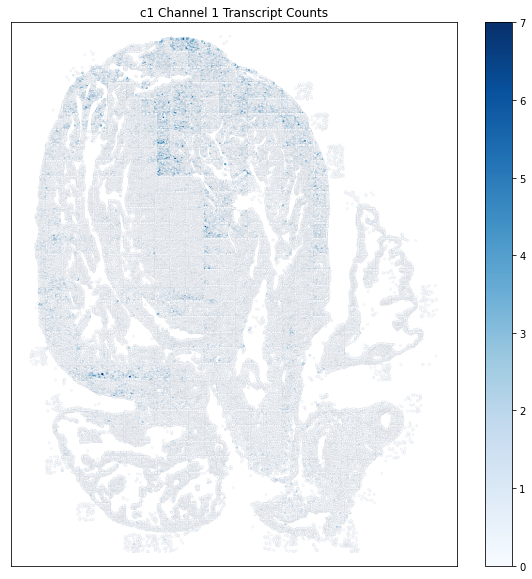

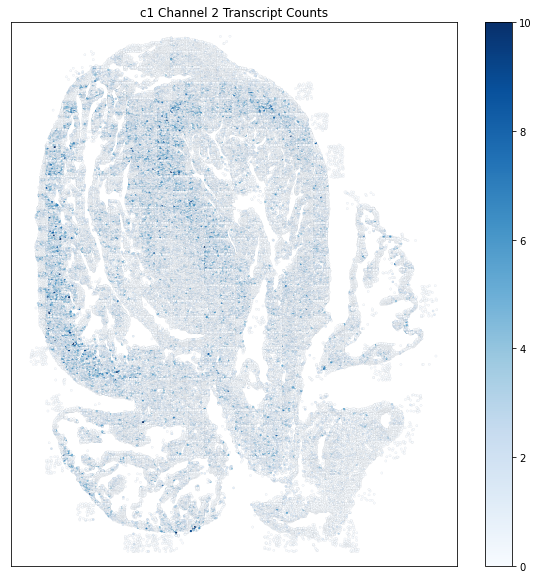

In [51]:

sg.theme("LightGray")
def main():
    font = ("Arial", 16, "bold")
    options = [
        #saving parameters for future runs 
        [   
            sg.Text("Save a path", font=font),
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Select a preset"),
            sg.Input(size=(25, 1), key="-PRESETS-"),
            sg.FolderBrowse(initial_folder="/home/ecxu/smFISH_parameters/path_presets"),
        ],
        [
            sg.Text("Directory of the smFISH .dax files"),
            sg.Input(size=(25, 1), key="-FOLDER-"),
            sg.FolderBrowse(initial_folder="/mnt/merfish4v1/RNA_MERFISH/MERlin_Data/E20220820_R0110_N2S11AcrySeq"),
        ],
        [
            sg.Text("Enter a folder location to store the drifts"),
            sg.Input(size=(25, 1), key="-Drifts-"),
            sg.FolderBrowse(initial_folder="/home/ecxu/smFISH_parameters/drifts"),
        ],
        [
            sg.Text("Output directory to store the smFISH spot count files"),
            sg.Input(size=(25, 1), key="-SPOTS-"),
            sg.FolderBrowse(initial_folder="/home/ecxu/smFISH_parameters/spot_count"),
        ],
        [
            sg.Text("Segmentation Folder"),
            sg.Input(size=(25, 1), key="-Segmentation-"),
            sg.FolderBrowse(initial_folder="/storage/RNA_MERFISH/Segmentation"),
        ],
        [
            sg.Text("Combinatorial MERFISH Images Folder"),
            sg.Input(size=(25, 1), key="-MERFISH-"),
            sg.FolderBrowse(initial_folder="/mnt/merfish4v1/RNA_MERFISH/MERlin_Data/E20220820_R0110_N2S11AcrySeq"),
        ],
        [
            sg.Text("Flatfields Folder (If no flatfields in folder, they will be computed)"),
            sg.Input(size=(25, 1), key="-Flatfields-"),
            sg.FolderBrowse(initial_folder="/home/ecxu/smFISH_parameters/flatfields"),
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Start smFISH Quantification", font=font),
        ],
        [
            sg.Text(""),
        ],
        # [
        #     sg.Text("Directory of the smFISH .dax files"),
        #     sg.Input(size=(25, 1), key="-FOLDER-"),
        #     sg.FolderBrowse(initial_folder="/home/ecxu"),
        # ],
        # [
        #     sg.Text("Enter a folder location to store the drifts"),
        #     sg.Input(size=(25, 1), key="-Drifts-"),
        #     sg.FolderBrowse(initial_folder="/home"),
        # ],
        # [
        #     sg.Text("Output directory to store the smFISH spot count files"),
        #     sg.Input(size=(25, 1), key="-SPOTS-"),
        #     sg.FolderBrowse(),
        # ],
        # [
        #     sg.Text("Segmentation Folder"),
        #     sg.Input(size=(25, 1), key="-Segmentation-"),
        #     sg.FolderBrowse(),
        # ],
        # [
        #     sg.Text("Combinatorial MERFISH Images Folder"),
        #     sg.Input(size=(25, 1), key="-MERFISH-"),
        #     sg.FolderBrowse(),
        # ],
        # [
        #     sg.Text("Flatfields Folder (If no flatfields in folder, they will be computed)"),
        #     sg.Input(size=(25, 1), key="-Flatfields-"),
        #     sg.FolderBrowse(),
        # ],
        [
            sg.Text("Hyb Round Number i.e. 3"),
            sg.Input(size=(9, 1), key="-HybRound-"),
            sg.Text("Gene in channel 1 i.e. tnnt2"),
            sg.Input(size=(9, 1), key="-GONE-"),
            sg.Text("Gene in channel 2 i.e. acta2"),
            sg.Input(size=(9, 1), key="-GTWO-"),
        ],
        [
            sg.Button("Run smFISH")
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Display Fits", font=font),
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Enter a file location of an image of fits"),
            sg.Input(size=(25, 1), key="-Fits-"),
            sg.FileBrowse(initial_folder="/home/ecxu/smFISH_parameters/spot_count"),
        ],
        [
            sg.Button("Display Fits"),
            sg.Button("Remove Display")
        ],
        [
            sg.Image(key="-ALLFITS-")
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Display Mosaic", font=font),
        ],
        [
            sg.Text(""),
        ],
        [
            sg.Text("Enter a file location of the MERFISH Scanpy object"),
            sg.Input(size=(25, 1), key="-SCANPY-"),
            sg.FileBrowse(),
        ],
        [
            sg.Text("Gene Name"),
            sg.Input(size=(10, 1), key="-gname-"),
            sg.Text("Channel 1 or 2"),
            sg.Input(size=(10, 1), key="-channel-"),
        ],
        [
            sg.Text("vmax"),
            sg.Input(size=(10, 1), key="-vmax-"),
            sg.Text("vmin"),
            sg.Input(size=(10, 1), key="-vmin-"),
            sg.Text("Annotate FOVs (y/n)"),
            sg.Input(size=(10, 1), key="-afov-"),            
            sg.Button("Display")
        ],                  
    ]
    items_chosen = [[sg.Image(key="-MOSAIC-")]]
    choices = [[sg.Frame('', layout= options)]]
    tab2_layout = [  
        [[sg.Column(choices), sg.Column(items_chosen)]]
    ]

    #layout = [[sg.T("")],[sg.Image(key="-IMAGE-")],[sg.Text("Choose a file: "), sg.Input(size=(25, 1)), sg.FileBrowse(key="-IN-")],[sg.Button("Submit")]]
    #tab1_layout = [
    #    [sg.Text("TBD"),],
    #]
    #layout = [[sg.TabGroup([[sg.Tab('Calculate Spots', tab1_layout),
    #                   sg.Tab('Display Mosaic', tab2_layout)
    #                   ]])]]
    ###Building Window
    window = sg.Window('smFISH Mosaic Show', tab2_layout, size=(1400,2400), resizable=True)

    while True:
        event, values = window.read()
        
        if event == sg.WIN_CLOSED or event=="Exit":
            break
        # display mosaic
        elif event == "Display":
            try:
                window["-MOSAIC-"].update(data=display_mosaic(values["-FOLDER-"], values["-SCANPY-"], values["-SPOTS-"], values["-vmax-"], values["-vmin-"], values["-afov-"], values["-channel-"], values["-gname-"]))  
            except:
                print("Try changing parameters")
        elif event == "Display Fits":
            try:
                window["-ALLFITS-"].update(data=displayfits(values['-Fits-']))
            except:
                print('select fit file')
        elif event == "Remove Display":
            try:
                window["-ALLFITS-"].update(data=None)  
            except:
                print("Try changing parameters")
        elif event == "Run smFISH":
            try:
                calculate_spots(values["-Segmentation-"], values["-FOLDER-"], values["-HybRound-"], values["-Flatfields-"], values["-MERFISH-"], values["-Drifts-"], values["-SPOTS-"])
            except Exception as e:
            # ... PRINT THE ERROR MESSAGE ... #
                print(e)

    window.close()
if __name__ == "__main__":
    main()